In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import json
import time
import logging

import implicit
from implicit import bpr, als, nearest_neighbours, approximate_als

from scipy.sparse import coo_matrix, csr_matrix, save_npz, load_npz

logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylog.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

# Load Data

In [2]:
DATA_FOLDER = "../input"
TMP_FOLDER = os.path.join(DATA_FOLDER, "tmp")
IMPLICIT_FOLDER = os.path.join(TMP_FOLDER, 'implicit_interest')

train_matrix_file_name = 'train_matrix.npz'
test_csv_file_name = 'test_interactions.csv'
train_csv_file_name = 'train_interactions.csv'
metadata_file_name = 'metadata.json'

In [3]:
train_matrix = load_npz(os.path.join(IMPLICIT_FOLDER, train_matrix_file_name))
test_df = pd.read_csv(os.path.join(IMPLICIT_FOLDER, test_csv_file_name), dtype=str)
train_df = pd.read_csv(os.path.join(IMPLICIT_FOLDER, train_csv_file_name), dtype=str)
with open(os.path.join(IMPLICIT_FOLDER, metadata_file_name), 'r') as fp:
    metadata = json.load(fp)

# Train and Validate Model

In [4]:
def top_k_accuracy(ground_series, rec_dict, k):
    if k == 0:
        return 0
    
    acc = 0
    count = 0
    for user_id in test_user_item_index.index.levels[0]:
        top_k_rec = rec_dict[user_id][0:min(k, len(rec_dict[user_id]))]
        if ground_series[user_id].shape[0] == 0:
            continue
        
        # number of intersetion items
        num_match = ground_series[user_id].isin(top_k_rec).map(lambda ele: 1.0 if ele else 0.0).sum()
        
        acc += num_match / min(len(top_k_rec), ground_series[user_id].shape[0])
        
        count += 1
        
    acc /= count
    
    return acc

def top_k_accuracy_bins(ground_series, rec_dict, k, train_series, bins=5):
    if k == 0:
        return 0
    
    acc = dict()
    count = dict()
    for user_id in test_user_item_index.index.levels[0]:
        top_k_rec = rec_dict[user_id][0:min(k, len(rec_dict[user_id]))]
        if ground_series[user_id].shape[0] == 0:
            continue
            
        bin_index = (train_series[user_id].shape[0] // bins) * bins
        
        # number of intersetion items
        num_match = ground_series[user_id].isin(top_k_rec).map(lambda ele: 1.0 if ele else 0.0).sum()
        
        if bin_index not in acc:
            acc[bin_index] = 0.0
            count[bin_index] = 0
        acc[bin_index] += num_match / min(len(top_k_rec), ground_series[user_id].shape[0])
        count[bin_index] += 1
        
    for bin_index in acc.keys():
        acc[bin_index] /= count[bin_index]
    
    return pd.Series(acc, index=sorted(list(acc.keys())))

In [5]:
test_user_item = test_df.groupby('USER_ID').apply(lambda group: group['ITEM_ID'])
test_user_item_index = test_user_item.map(lambda ele: metadata['item_index'][ele])

In [6]:
train_user_item = train_df.groupby('USER_ID').apply(lambda group: group['ITEM_ID'])
train_user_item_index = train_user_item.map(lambda ele: metadata['item_index'][ele])

In [7]:
test_user_item_index.index.levels[0]

Index(['00012cdf-8ff9-4c9d-a7db-11b9c4b6eede',
       '00014a37-91ac-4453-8c27-87df46a9959f',
       '000186cc-93aa-4668-9e56-242944ec03c5',
       '0001bade-a221-44d7-b5b0-cbdc1e467b9b',
       '0001d25b-19ae-4d51-9de3-4c921ddf5ea5',
       '0001ded5-708a-4ab6-ba0c-1d9084a968a9',
       '00021c2c-0a45-4362-b0fd-482db3186b6e',
       '000246d5-530e-4f3e-b4e7-81de4369aad4',
       '00027cb1-9945-401b-b80d-a25efa418093',
       '0002a7eb-b8e9-4bd4-94d0-45c2e6541384',
       ...
       '26644ff6-a1b1-45cb-a75c-f3e37453d632',
       '2664aa5b-5cd9-4bc7-9ef8-7f82b8441066',
       '2664ae12-8a77-4338-b7d7-56b8f71b6df6',
       '26653649-0c7d-4840-ab49-9c8e1d7666e1',
       '2665379b-cf53-4a0f-bcce-6d4491568fc2',
       '26656774-2b3a-44ed-b737-874fff4d93c2',
       '26658082-0ec5-4c28-a86a-a75e84cc6c54',
       '2665ce36-a9d9-45fc-a0bf-13441e55dcaa',
       '26661bd5-3b18-47c4-8b50-b0b93956a96b',
       '266653ea-69dd-4c6e-93f3-ff906380e7b0'],
      dtype='object', name='USER_ID', length=311

## BPR

### Training

In [8]:
model_name = "bpr"

In [9]:
model = bpr.BayesianPersonalizedRanking(iterations=1000, factors=100)

In [10]:
start = time.time()
model.fit(train_matrix)
print("trained model '%s' in %s", model_name, time.time() - start)

100%|██████████| 1000/1000 [01:13<00:00, 13.67it/s, correct=99.88%, skipped=0.24%]

trained model '%s' in %s bpr 73.78462886810303


### Testing

In [11]:
rec_train_user_item_index = dict()
for user_id in train_user_item_index.index.levels[0]:
    rec_res = model.recommend(metadata['user_index'][user_id], train_matrix, N=10)
    rec_res = [ele[0] for ele in rec_res]
    rec_train_user_item_index[user_id] = rec_res

In [12]:
top_k_accuracy(train_user_item_index, rec_train_user_item_index, 10)

0.8028668732560104

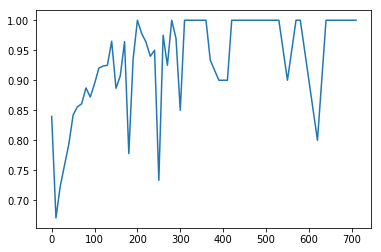

In [13]:
topkbins = top_k_accuracy_bins(train_user_item_index, rec_train_user_item_index, 10, train_user_item_index, bins=10)
topkbins.plot(kind='line')

In [14]:
rec_test_user_item_index = dict()
for user_id in test_user_item_index.index.levels[0]:
    rec_res = model.recommend(metadata['user_index'][user_id], train_matrix, N=10, filter_items=train_user_item_index[user_id].values.tolist())
    rec_res = [ele[0] for ele in rec_res]
    rec_test_user_item_index[user_id] = rec_res

In [15]:
top_k_accuracy(test_user_item_index, rec_test_user_item_index, 10)

0.16904816713139018

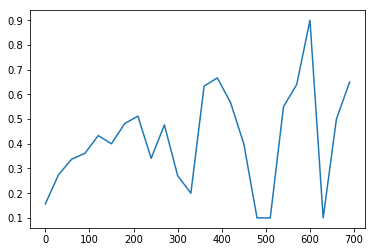

In [16]:
topkbins = top_k_accuracy_bins(test_user_item_index, rec_test_user_item_index, 10, train_user_item_index, bins=30)
topkbins.plot(kind='line')

## ALS

### Training

In [17]:
model_name = "als"

In [18]:
model = als.AlternatingLeastSquares(calculate_training_loss=True, iterations=50, factors=100)

In [19]:
start = time.time()
model.fit(train_matrix)
print("trained model '%s' in %s", model_name, time.time() - start)

100%|██████████| 50.0/50 [00:24<00:00,  1.97it/s, loss=5.63e-5]

trained model '%s' in %s als 24.940964937210083


### Testing

In [20]:
rec_train_user_item_index = dict()
for user_id in train_user_item_index.index.levels[0]:
    rec_res = model.recommend(metadata['user_index'][user_id], train_matrix, N=10, filter_already_liked_items=False)
    rec_res = [ele[0] for ele in rec_res]
    rec_train_user_item_index[user_id] = rec_res

In [21]:
top_k_accuracy(train_user_item_index, rec_train_user_item_index, 10)

0.1495977320038591

In [22]:
rec_test_user_item_index = dict()
for user_id in test_user_item_index.index.levels[0]:
    rec_res = model.recommend(metadata['user_index'][user_id], train_matrix, N=10, filter_items=train_user_item_index[user_id].values.tolist())
    rec_res = [ele[0] for ele in rec_res]
    rec_test_user_item_index[user_id] = rec_res

In [23]:
top_k_accuracy(test_user_item_index, rec_test_user_item_index, 10)

0.09151674663591054